### Pull data from database using SQL queries and store the data in pandas dataframe for data analysis

In [1]:
import psycopg2
import psycopg2.extras
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy
from scipy.stats import ks_2samp
from scipy import stats
import statsmodels.api as sm
from config2 import params2

#set options for displaying all the columns and rows
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [2]:
# pull all the necessary data from multiple table using joins
conn = psycopg2.connect(**params2)
cursor = conn.cursor()
stmt = ("""select 
                pd.id AS program_date_id, 
                s.school_name, 
                p.program_name, 
                l.name AS campus_location, 
                pd.start_date,
                pd.end_date, 
                pd.graduation_rate, 
                pd.median_salary_180days   
            FROM bootcamps_edu.School s 
            JOIN bootcamps_edu.School_Program_Location spl 
                ON s.id=spl.school_id 
            JOIN bootcamps_edu.Program p 
                ON p.id = spl.program_id 
            JOIN bootcamps_edu.Location l 
                ON l.id = spl.location_id
            JOIN bootcamps_edu.Program_Date pd 
                ON pd.school_program_location_id = spl.id;""")
cursor.execute(stmt)
result = cursor.fetchall()
print(result)

#create a list of columns names and create dataframe with pulled data and columns names
columns = ['id', 'school_name', 'program_name', 'campus_location', 'start_date', 'end_date', 'graduation_rate','median_salary_180days']
df = pd.DataFrame(result, columns=columns)


[(41, 'The Tech Academy', 'Python Developer BootCamp', 'Online', datetime.date(2021, 1, 1), datetime.date(2021, 6, 30), Decimal('78.3'), Decimal('52000')), (1, 'The Tech Academy', 'Python Developer BootCamp', 'Online', datetime.date(2021, 7, 1), datetime.date(2021, 12, 31), Decimal('82.4'), Decimal('65000')), (2, 'The Tech Academy', 'Data Science BootCamp', 'Online', datetime.date(2021, 1, 1), datetime.date(2021, 6, 30), Decimal('100.0'), Decimal('45180')), (67, 'Turing School of Software and Design', 'Back End Engineering', 'Online', datetime.date(2022, 1, 1), datetime.date(2022, 6, 30), Decimal('62.1'), Decimal('85000.00')), (39, 'Turing School of Software and Design', 'Back End Engineering', 'Online', datetime.date(2021, 7, 1), datetime.date(2021, 12, 31), Decimal('48.1'), Decimal('86500')), (3, 'Turing School of Software and Design', 'Back End Engineering', 'Online', datetime.date(2021, 1, 1), datetime.date(2021, 6, 30), Decimal('68.0'), Decimal('75000')), (33, 'Codeup', 'Full-Stac

In [3]:
#pull the skills' names from table Skill, add each skill name as column to the dataframe and set values to null
stmt = ("select Skill from bootcamps_edu.Skill")
cursor.execute(stmt)
result = cursor.fetchall()
print(result)
skills = [r[0] for r in result]
for skill in skills:
    df[skill] = None


[('java',), ('csharp_net',), ('html',), ('css',), ('javascript',), ('es6',), ('jquery',), ('nodejs',), ('reactjs',), ('redux',), ('heroku',), ('sql',), ('mysql',), ('postgress',), ('mongodb',), ('firebase',), ('git',), ('spring',), ('api',), ('applied_stats',), ('python',), ('r',), ('regression',), ('classification',), ('clustering',), ('time_series_analysis',), ('anomaly_detection',), ('language_processing',), ('machine_learning',), ('advanced_topics',), ('story_telling_with_data',), ('domain_expertise_development',)]


In [4]:
#pull each program id and each skill taught at each program
stmt = ("""select 
                pd.id, 
                sk.skill 
            from bootcamps_edu.Skill sk 
            JOIN bootcamps_edu.Program_Skill ps 
                ON ps.skill_id = sk.id 
            JOIN bootcamps_edu.Program_Date pd 
                ON ps.school_program_date_id = pd.id""")
cursor.execute(stmt)
result = cursor.fetchall()
print(result)
cursor.close()

[(1, 'java'), (1, 'csharp_net'), (1, 'html'), (1, 'css'), (1, 'javascript'), (1, 'es6'), (1, 'jquery'), (1, 'nodejs'), (1, 'reactjs'), (1, 'redux'), (1, 'heroku'), (1, 'sql'), (1, 'mysql'), (1, 'postgress'), (1, 'mongodb'), (1, 'firebase'), (1, 'git'), (1, 'spring'), (1, 'api'), (1, 'applied_stats'), (1, 'python'), (1, 'r'), (1, 'regression'), (1, 'classification'), (1, 'clustering'), (1, 'time_series_analysis'), (1, 'anomaly_detection'), (1, 'language_processing'), (1, 'machine_learning'), (1, 'advanced_topics'), (1, 'story_telling_with_data'), (1, 'domain_expertise_development'), (2, 'java'), (2, 'csharp_net'), (2, 'html'), (2, 'css'), (2, 'javascript'), (2, 'es6'), (2, 'jquery'), (2, 'nodejs'), (2, 'reactjs'), (2, 'redux'), (2, 'heroku'), (2, 'sql'), (2, 'mysql'), (2, 'postgress'), (2, 'mongodb'), (2, 'firebase'), (2, 'git'), (2, 'spring'), (2, 'api'), (2, 'applied_stats'), (2, 'python'), (2, 'r'), (2, 'regression'), (2, 'classification'), (2, 'clustering'), (2, 'time_series_analysi

In [5]:
# sort id values in descending order
df = df.sort_values(['id'])

# reset index number to be in order
df = df.reset_index(drop=True)


In [6]:
# insert 1 for each skill present at the program for appropriate program id
for r in result:
    df.loc[r[0]-1, r[1]] = 1

### Exploratory Data Analysis

In [7]:
sns.set()

In [8]:
#we see that most null values are present in skills
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            67 non-null     int64 
 1   school_name                   67 non-null     object
 2   program_name                  67 non-null     object
 3   campus_location               67 non-null     object
 4   start_date                    67 non-null     object
 5   end_date                      67 non-null     object
 6   graduation_rate               67 non-null     object
 7   median_salary_180days         67 non-null     object
 8   java                          62 non-null     object
 9   csharp_net                    62 non-null     object
 10  html                          62 non-null     object
 11  css                           62 non-null     object
 12  javascript                    62 non-null     object
 13  es6                   

In [9]:
df.columns

Index(['id', 'school_name', 'program_name', 'campus_location', 'start_date',
       'end_date', 'graduation_rate', 'median_salary_180days', 'java',
       'csharp_net', 'html', 'css', 'javascript', 'es6', 'jquery', 'nodejs',
       'reactjs', 'redux', 'heroku', 'sql', 'mysql', 'postgress', 'mongodb',
       'firebase', 'git', 'spring', 'api', 'applied_stats', 'python', 'r',
       'regression', 'classification', 'clustering', 'time_series_analysis',
       'anomaly_detection', 'language_processing', 'machine_learning',
       'advanced_topics', 'story_telling_with_data',
       'domain_expertise_development'],
      dtype='object')

In [10]:
# from info() above we see that majority columns have values stored as strings, for further analysis we will convert them to decimal values
cols_list = ['graduation_rate', 'median_salary_180days', 'java',
       'csharp_net', 'html', 'css', 'javascript', 'es6', 'jquery', 'nodejs',
       'reactjs', 'redux', 'heroku', 'sql', 'mysql', 'postgress', 'mongodb',
       'firebase', 'git', 'spring', 'api', 'applied_stats', 'python', 'r',
       'regression', 'classification', 'clustering', 'time_series_analysis',
       'anomaly_detection', 'language_processing', 'machine_learning',
       'advanced_topics', 'story_telling_with_data',
       'domain_expertise_development']
df[cols_list] = df[cols_list].astype(float)

In [11]:
df.describe()

,id,graduation_rate,median_salary_180days,java,csharp_net,html,css,javascript,es6,jquery,nodejs,reactjs,redux,heroku,sql,mysql,postgress,mongodb,firebase,git,spring,api,applied_stats,python,r,regression,classification,clustering,time_series_analysis,anomaly_detection,language_processing,machine_learning,advanced_topics,story_telling_with_data,domain_expertise_development
count,67.000000,67.000000,67.000000,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0
mean,34.000000,85.122388,71595.492537,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,19.485037,12.652701,23598.960114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,48.100000,37440.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,17.500000,80.950000,57060.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,34.000000,89.300000,65000.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,50.500000,94.700000,75000.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,67.000000,100.000000,140000.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


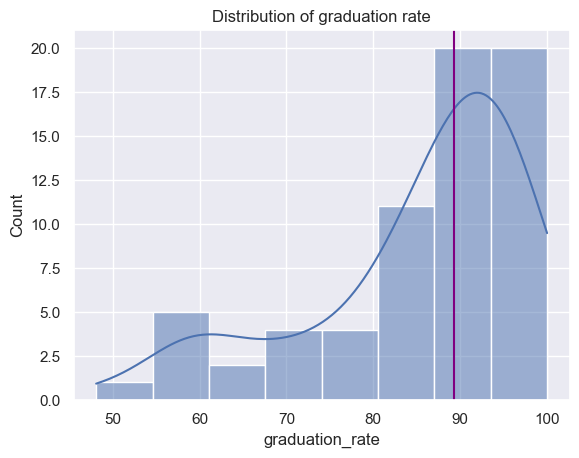

In [12]:
#distribution of graduation rate
xmedian = np.median(df['graduation_rate'])
sns.histplot(data = df, x = 'graduation_rate', kde=True)
plt.axvline(xmedian, c = "purple")
plt.title("Distribution of graduation rate");

#### Graduation rate is the percentage of students that completed the program on time.
#### The graduation rate is left skewed.
#### The median is close to 90%

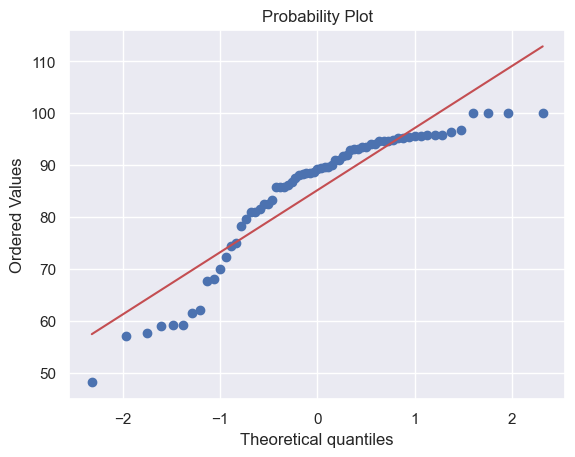

In [13]:
scipy.stats.probplot(df['graduation_rate'].dropna(),dist='norm',plot=sns.mpl.pyplot);

### The qq-plot confirms that the graduation rate is not normally distributed.

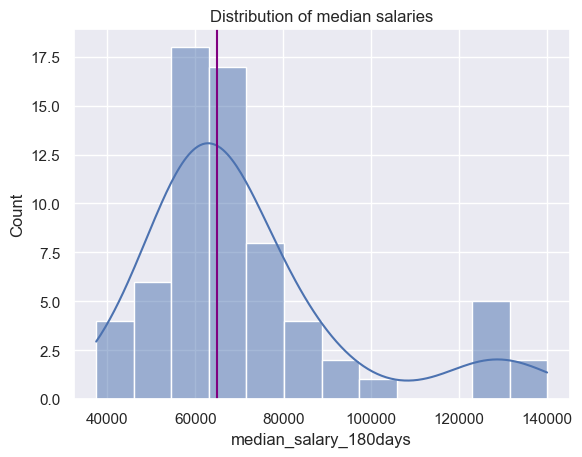

In [14]:
#distribution of median salary 180 days after graduation
xmedian = np.median(df['median_salary_180days'])
sns.histplot(data = df, x = 'median_salary_180days',kde=True)
plt.axvline(xmedian,c = "purple")
plt.title("Distribution of median salaries");

### The distribution of the median salaries is right skewed. There are extreme outliers.
### The median salary for the programs is around 60000+.


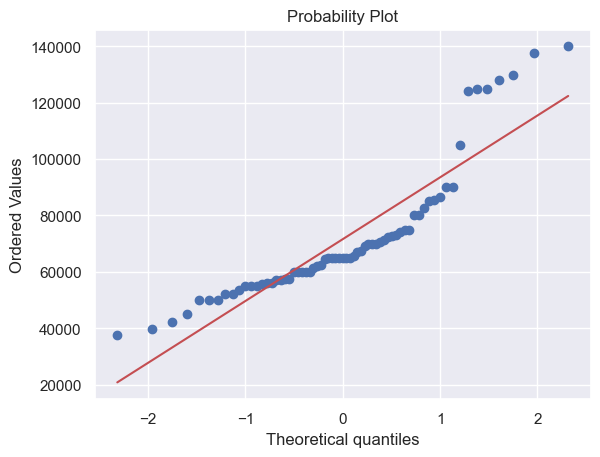

In [15]:
scipy.stats.probplot(df['median_salary_180days'].dropna(),dist='norm',plot=sns.mpl.pyplot);

### The qq-plot confirms that the distribution of median salaries is not normal.

### KS test

#### The null hypothesis: There are no significant difference between median salaries distributions for remote and onsite positions

In [16]:
# Subset data by program location
remote = ['Online','Remote']
onsite = ['Boston', 'Chicago', 'Cincinnati', 'Cleveland', 'Columbus', 'Dallas', 'Los Angeles', 'New York', 'Philadelphia', 
         'Pittsburgh', 'Salt Lake City', 'San Antonio','San Antonio - Vogue', 'Tokyo', 'Toronto', 'Wilmington']
location1 = df[df['campus_location'].isin(remote)]['median_salary_180days']
location2 = df[df['campus_location'].isin(onsite)]['median_salary_180days']

# Perform KS test
statistic, p_value = ks_2samp(location1, location2)


print("KS test statistic:", statistic)
print("p-value:", p_value)

KS test statistic: 0.29554263565891475
p-value: 0.10495022255796234


#### H0: There are no significant difference between median salaries distributions for remote and onsite positions
#### The p-value (0.10495022255796234) > 0.05, we fail to reject the null hypothesis.
#### There is no signicant influence of location on median salary outcome.



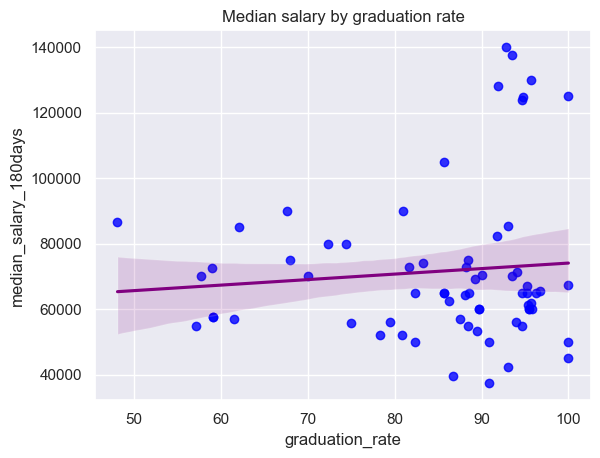

In [17]:
sns.regplot(data = df, x='graduation_rate',y='median_salary_180days', scatter_kws={'color': 'blue'}, line_kws={'color':'purple'})
plt.title('Median salary by graduation rate');

### There is no obvious correlation between graduation rate and median salary.
### The program success rate doesn't influence on obtaining higher salaries.

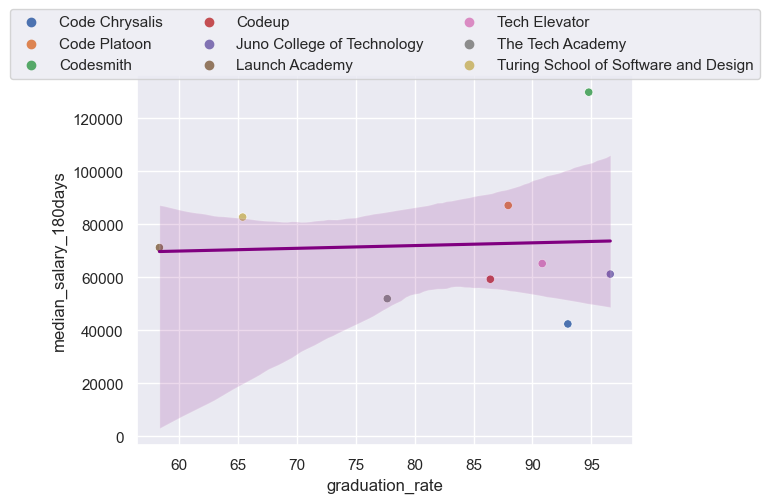

In [18]:
mean_grad_rate = df.groupby('school_name')['graduation_rate'].mean().reset_index()
avg_medsalary = df.groupby('school_name')['median_salary_180days'].mean().reset_index()
merged = pd.merge(mean_grad_rate,avg_medsalary, on='school_name')
sns.scatterplot(data=merged, x='graduation_rate',y='median_salary_180days',hue='school_name', legend='auto')
sns.regplot(data=merged, x='graduation_rate', y='median_salary_180days', scatter=False, color='purple')
legend = plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3);


### We can see the same behaviour when we calculate average graduation rate and average salary
### grouping for school.

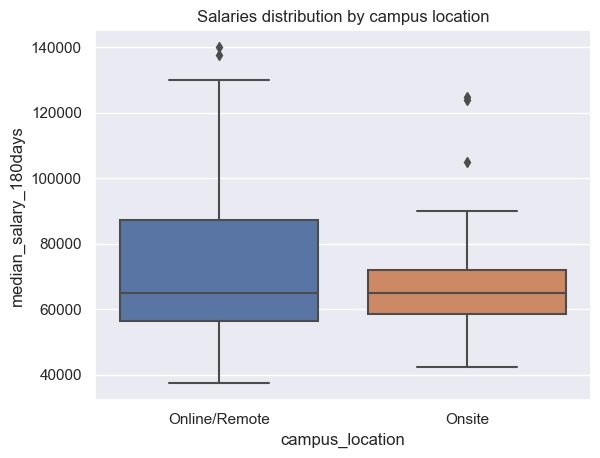

In [19]:
sns.boxplot(x= df['campus_location'].apply(lambda x: "Online/Remote" if x in ['Online','Remote'] else 'Onsite'), y = df['median_salary_180days'])
plt.title('Salaries distribution by campus location');

### This box plox confirms the results of the KS test.
### The median of median salaries are about the same for remote and onsite programs.

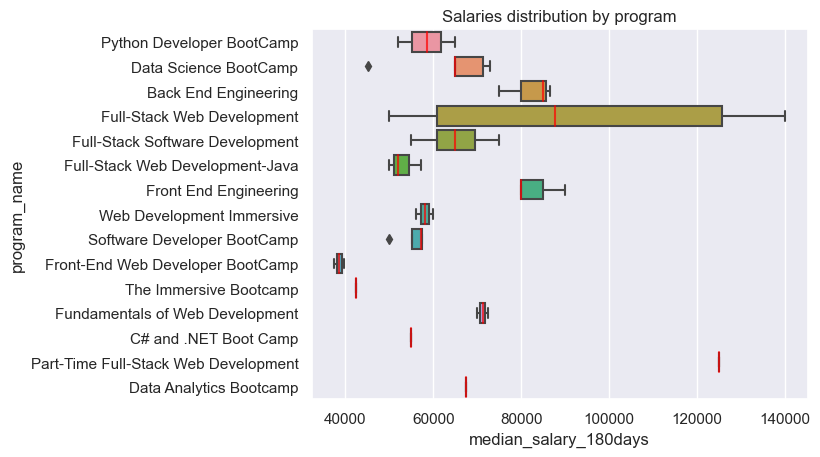

In [20]:
sns.boxplot(x = df['median_salary_180days'], y = df['program_name'], medianprops=dict(color="red", alpha=0.7))
plt.title('Salaries distribution by program');

### It looks like the higher salaries are for Full-Stack Web Development programs.

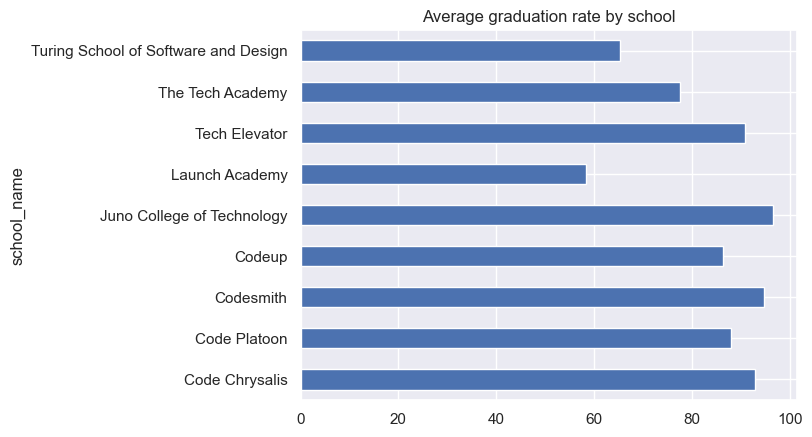

In [21]:

avg_graduation = df.groupby('school_name')['graduation_rate'].mean()
avg_graduation.plot(kind ='barh')
plt.title('Average graduation rate by school');

### Graduation rate is very high for majority of schools, except Launch Academy which shows a graduation rate less than 60%.

In [22]:
# select just the columns containing skills
cols =  ['java', 'csharp_net', 'html', 'css', 'javascript', 'es6', 'jquery',
       'nodejs', 'reactjs', 'redux', 'heroku', 'sql', 'mysql', 'postgress',
       'mongodb', 'firebase', 'git', 'spring', 'api', 'applied_stats',
       'python', 'r', 'regression', 'classification', 'clustering',
       'time_series_analysis', 'anomaly_detection', 'language_processing',
       'machine_learning', 'advanced_topics', 'story_telling_with_data',
       'domain_expertise_development']
# create new dataframe that just contains the skills
skills_df = df[cols]

In [23]:
skills_count = pd.DataFrame(skills_df.apply(lambda x: x.count()))

# sort skills occurencies in descending order
skills_count.rename(columns= { 0:'skill_freq'},inplace=True)
skills_count = skills_count.sort_values(['skill_freq'],ascending=False)


In [34]:
skills_count

,skill_freq
java,62
csharp_net,62
story_telling_with_data,62
advanced_topics,62
machine_learning,62
language_processing,62
anomaly_detection,62
time_series_analysis,62
clustering,62
classification,62


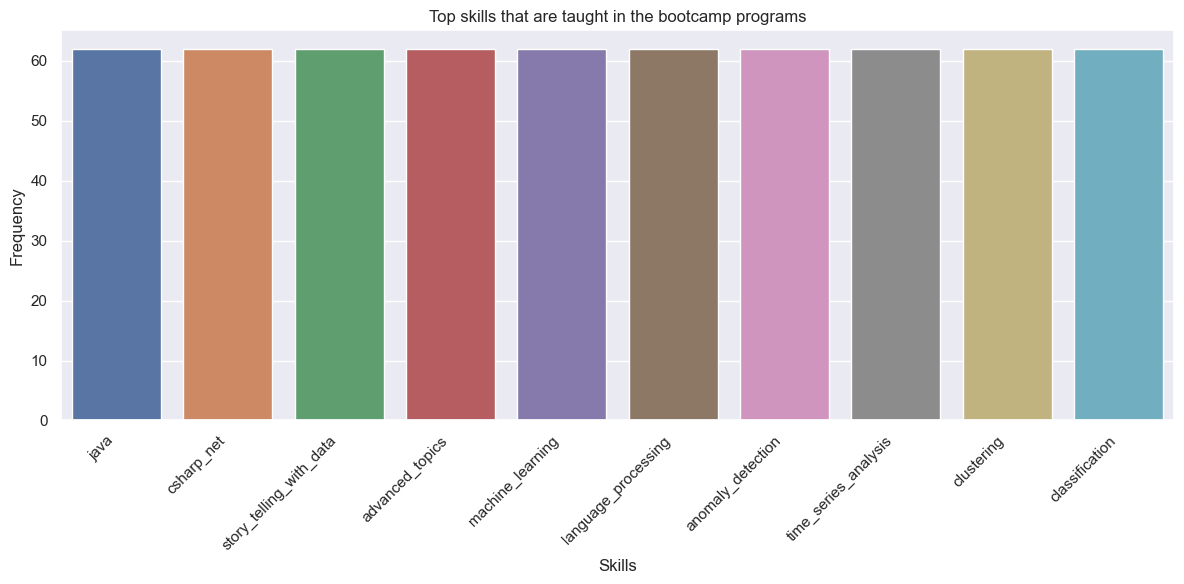

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=skills_count[:10], x=skills_count[:10].index, y=skills_count[:10]['skill_freq'], ax=ax)
ax.set_title("Top skills that are taught in the bootcamp programs")
ax.set_xlabel("Skills")
ax.set_ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout();


## Confirmatory Data Analysis

In [25]:
q1 = df['median_salary_180days'].quantile(0.25)
q3 = df['median_salary_180days'].quantile(0.75)

iqr = q3 - q1
upper = q3 + (iqr * 2)
lower = q3 - (iqr * 2)

df_norm = df[(df['median_salary_180days'] > lower) & (df['median_salary_180days'] < upper)]

In [26]:
df_norm['median_salary_180days'].describe()

count        59.000000
mean      65253.525424
std       12559.197582
min       39720.000000
25%       56580.000000
50%       65000.000000
75%       71950.000000
max      105000.000000
Name: median_salary_180days, dtype: float64

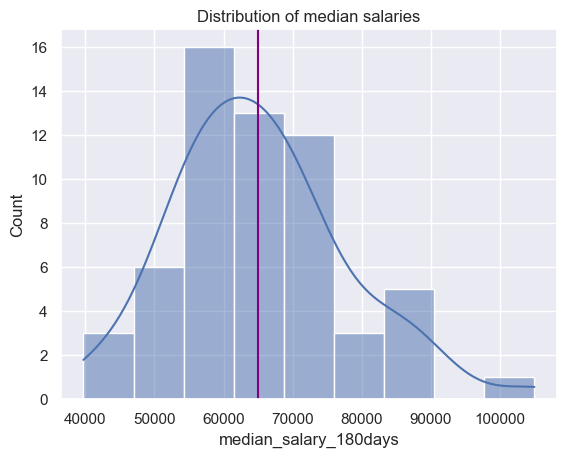

In [27]:
#distribution of median salary 180 days after graduation (data after removing outlier in median salary)
xmedian = np.median(df_norm['median_salary_180days'])
sns.histplot(data = df_norm, x = 'median_salary_180days',kde=True)
plt.axvline(xmedian,c = "purple")
plt.title("Distribution of median salaries");

In [28]:
z_scores = stats.zscore(df['median_salary_180days'])
threshold = 2
df_filtered = df[abs(z_scores) <= threshold]

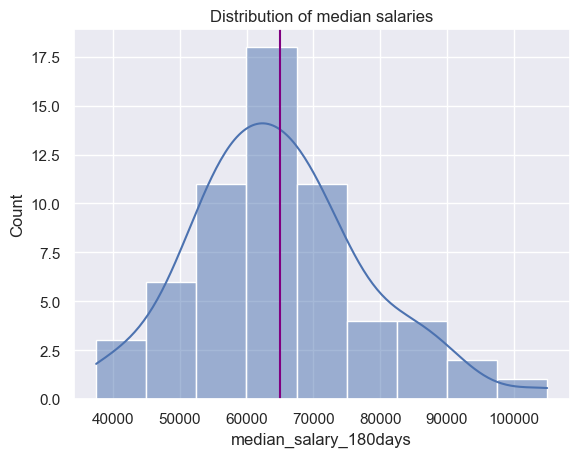

In [29]:
#distribution of median salary 180 days after graduation (data after removing outlier in median salary)
xmedian = np.median(df_filtered['median_salary_180days'])
sns.histplot(data = df_filtered, x = 'median_salary_180days',kde=True)
plt.axvline(xmedian,c = "purple")
plt.title("Distribution of median salaries");

In [30]:
df.var()

/var/folders/kc/j4ss26096jv9xkwkcr7z36kr0000gn/T/ipykernel_59135/1568254755.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.var()


id                              3.796667e+02
graduation_rate                 1.600909e+02
median_salary_180days           5.569109e+08
java                            0.000000e+00
csharp_net                      0.000000e+00
html                            0.000000e+00
css                             0.000000e+00
javascript                      0.000000e+00
es6                             0.000000e+00
jquery                          0.000000e+00
nodejs                          0.000000e+00
reactjs                         0.000000e+00
redux                           0.000000e+00
heroku                          0.000000e+00
sql                             0.000000e+00
mysql                           0.000000e+00
postgress                       0.000000e+00
mongodb                         0.000000e+00
firebase                        0.000000e+00
git                             0.000000e+00
spring                          0.000000e+00
api                             0.000000e+00
applied_st

<AxesSubplot: >

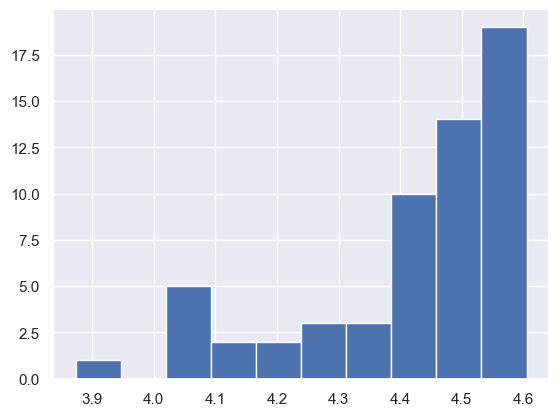

In [31]:
#normalizing 'graduation_rate' column with log normalization, plotting to see if there is a change in distribution
np.log(df_norm['graduation_rate']).hist()

In [32]:
df_norm.to_csv("/Users/anastasiyaayala/Desktop/bootcamps_edu/data/data_normal.csv",index=False)